In [16]:
import numpy as np
import csv
import networkx as nx
import time
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import multiprocessing as mp
from scipy.integrate import odeint


In [17]:
## Gillespie algorithm
### SIR model: agent-based simulation
def SIR_Gillespie(N, y_0, param,tag = 'SIR'):
    '''
    N: population size
    y_0: initial condition of the population
    param: dictionary of the parameters
    tag: output object
    '''
    # initialization
    beta, gamma = param['beta']/N, param['gamma']
    I_0 = int(N*y_0[1])
    t = [0]; S = [N - I_0]; I = [I_0]; R = [0]
    state = np.array([0]*S[0] + [1]*I[0]).reshape((N, )) # S: 0, I: 1, R: 2
    np.random.shuffle(state)
    prop = beta*I[0]*(state == 0) + gamma*(state == 1)
    
    # update
    while I[-1] > 0:
        r_1 = np.random.rand()
        r_2 = np.random.rand()
        cumsum = prop.cumsum()
        scale = cumsum[-1] # total rate, or beta*S[-1]*I[-1] + gamma*I[-1]
        tau = -np.log(1 - r_1)/scale # exponential distribution: inverse function
        t.append(t[-1] + tau)

        i = np.searchsorted(cumsum, r_2*scale)
        if state[i] == 0: 
            S.append(S[-1] - 1); I.append(I[-1] + 1); R.append(R[-1])
            state[i] = 1 # S to I
            prop[i] = gamma
        else:
            S.append(S[-1]); I.append(I[-1] - 1); R.append(R[-1] + 1)
            state[i] = 2 # I to R
            prop[i] = 0
        prop[state == 0] = beta*I[-1]

    if tag == 'SIR':
        S = np.array(S); I = np.array(I); R = np.array(R)
        solution = np.column_stack((S, I, R))
        return t, solution 
    else:
        return state


In [18]:
# well-mixed population
## ODE equation
### SIR model: numerical solution
def SIR_equation(y, t, param):
    beta, gamma = param['beta'], param['gamma']
    S, I, R = y
    return [-beta*S*I, beta*S*I - gamma*I, gamma*I]
def SIR(y_0, t, param):
    solution = odeint(SIR_equation, y_0, t, args = (param, ))
    return solution

# Generate a network complete graph
N = 1000
G = nx.complete_graph(N)


In [26]:
N = 1000
y_0 = [1 - 1e-2, 1e-2, 0]
t = np.linspace(0, 100, 1001)
param = {'beta': 0.35, 'gamma': 0.1}

# Solve ODE
solution_ode = SIR(y_0, t, param)
solution_ode = np.around(solution_ode, decimals=6)
print('ODE: ' + ", ".join([str(v) for v in solution_ode[-1]]))

# Solve Gillespie simulation
t_gillespie, solution_gillespie = SIR_Gillespie(N, y_0, param)

repetition = 100

start = time.time()
mean_SIR = np.zeros(3)
for i in range(repetition):
     t_1, solution_1 = SIR_Gillespie(N, y_0, param); mean_SIR += solution_1[-1]
mean_SIR = mean_SIR/repetition/N; mean_SIR = np.around(mean_SIR, decimals = 6)
end = time.time()
print('gillespie' + ': ' + ", ".join([str(v) for v in mean_SIR]))
print('time: ' + str(np.around(end - start, decimals = 6)))


ODE: 0.033729, 0.000745, 0.965526
gillespie: 0.03325, 0.0, 0.96675
time: 2.702765


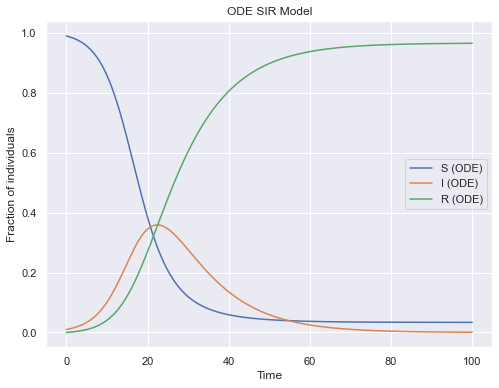

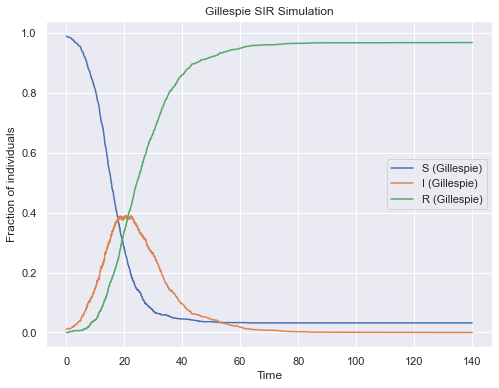

In [27]:
# Plot ODE results
plt.figure(figsize=(8, 6))
plt.plot(t, solution_ode[:, 0], label='S (ODE)')
plt.plot(t, solution_ode[:, 1], label='I (ODE)')
plt.plot(t, solution_ode[:, 2], label='R (ODE)')
plt.xlabel('Time')
plt.ylabel('Fraction of individuals')
plt.title('ODE SIR Model')
plt.legend()
plt.show()

# Plot Gillespie simulation results
plt.figure(figsize=(8, 6))
plt.plot(t_gillespie, solution_gillespie[:, 0]/N, label='S (Gillespie)')
plt.plot(t_gillespie, solution_gillespie[:, 1]/N, label='I (Gillespie)')
plt.plot(t_gillespie, solution_gillespie[:, 2]/N, label='R (Gillespie)')
plt.xlabel('Time')
plt.ylabel('Fraction of individuals')
plt.title('Gillespie SIR Simulation')
plt.legend()
plt.show()


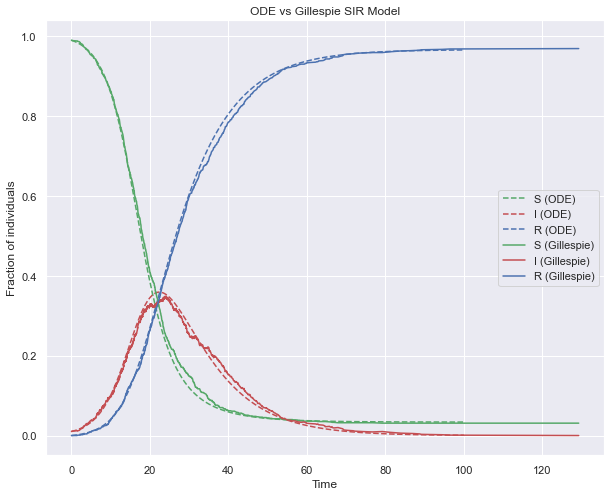

In [29]:
# Plot both ODE and Gillespie simulation results in the same graph
plt.figure(figsize=(10, 8))

# ODE results
plt.plot(t, solution_ode[:, 0], 'g--', label='S (ODE)')
plt.plot(t, solution_ode[:, 1], 'r--', label='I (ODE)')
plt.plot(t, solution_ode[:, 2], 'b--', label='R (ODE)')

# Gillespie results
plt.plot(t_gillespie, solution_gillespie[:, 0]/N, 'g', label='S (Gillespie)')
plt.plot(t_gillespie, solution_gillespie[:, 1]/N, 'r', label='I (Gillespie)')
plt.plot(t_gillespie, solution_gillespie[:, 2]/N, 'b', label='R (Gillespie)')

plt.xlabel('Time')
plt.ylabel('Fraction of individuals')
plt.title('ODE vs Gillespie SIR Model')
plt.legend()
plt.show()